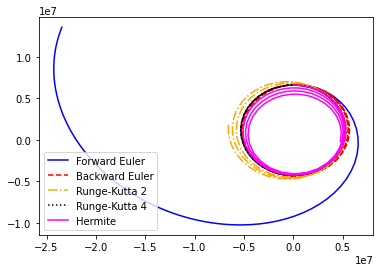

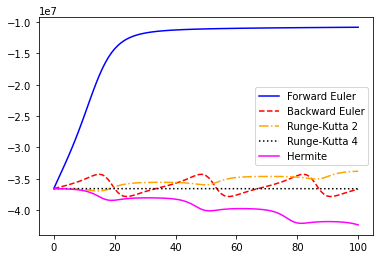

In [1]:
import math
import numpy as np
from matplotlib import pyplot
from matplotlib.lines import Line2D

G = 6.67408e-11  # m3 / (kg s^2)
central_mass = 5.972e24  # kg
central_radius = 6371e3  # m


def get_orbit_energy(pos, vel):
    energies = []
    for i in range(len(pos)):
        v = math.sqrt(vel[i][0] ** 2 + vel[i][1] ** 2)
        r = math.sqrt(pos[i][0] ** 2 + pos[i][1] ** 2)
        energies.append((v**2)/2 - (G*central_mass/r))

    return energies


def get_acc(pos):
    dist = math.sqrt(pos[0] ** 2 + pos[1] ** 2)
    direction = -(pos / dist)

    return ((G * central_mass) / (dist ** 2)) * direction


def propag_forward_euler(pos, vel, dt):
    acc = get_acc(pos)
    new_vel = vel + acc * dt
    new_pos = pos + vel * dt

    return new_pos, new_vel


def propag_backward_euler(pos, vel, dt):
    new_pos = pos + vel * dt
    new_vel = vel + get_acc(new_pos) * dt

    return new_pos, new_vel


def propag_rk2(pos, vel, dt):
    pos_e, vel_e = propag_forward_euler(pos, vel, dt)
    new_pos = pos + dt * (vel + vel_e)/2
    new_vel = vel + dt * (get_acc(pos) + get_acc(pos_e))/2

    return new_pos, new_vel


def propag_rk4(pos, vel, dt):
    k1v = get_acc(pos)
    k1r = vel
    k2v = get_acc(pos + k1r * dt/2)
    k2r = vel + k1v * dt/2
    k3v = get_acc(pos + k2r * dt/2)
    k3r = vel + k2v * dt/2
    k4v = get_acc(pos + k3r * dt)
    k4r = vel + k3v * dt

    new_vel = vel + dt/6 * (k1v + 2 * k2v + 2 * k3v + k4v)
    new_pos = pos + dt/6 * (k1r + 2 * k2r + 2 * k3r + k4r)
    return new_pos, new_vel


def hermite_predict(pos, vel, dt):
    dist = math.sqrt(pos[0] ** 2 + pos[1] ** 2)
    direction = -pos / dist
    acc = get_acc(pos)
    jerk = (G * central_mass) / (dist ** 3) * (vel - 3 * (np.dot(pos, vel) / dist) * direction)

    new_pos = pos + vel * dt + acc * dt * dt / 2 + jerk * dt * dt * dt / 6
    new_vel = vel + acc * dt + jerk * dt * dt / 2

    return new_pos, new_vel, acc, jerk


def hermite_correct(pos, vel, temp_pos, temp_vel, old_acc, old_jerk, dt):
    dist = math.sqrt(temp_pos[0] ** 2 + temp_pos[1] ** 2)
    direction = -temp_pos / dist
    acc = get_acc(temp_pos)
    jerk = (G * central_mass) / (dist ** 3) * (temp_vel - 3 * (np.dot(temp_pos, temp_vel) / dist) * direction)

    new_vel = vel + (old_acc + acc) * dt/2 + (old_jerk - jerk) * dt * dt/12
    new_pos = pos + (vel + new_vel) * dt/2 + (old_acc - acc) * dt * dt/12

    return new_pos, new_vel


def propag_hermite(pos, vel, dt):
    temp_pos, temp_vel, old_acc, old_jerk = hermite_predict(pos, vel, dt)
    new_pos, new_vel = hermite_correct(pos, vel, temp_pos, temp_vel, old_acc, old_jerk, dt)

    return new_pos, new_vel


def propagate(pos_0, vel_0, propag_func, dt, max_steps):
    positions = [pos_0]
    velocities = [vel_0]

    current_pos = pos_0
    current_vel = vel_0

    for i in range(max_steps):
        current_pos, current_vel = propag_func(current_pos, current_vel, dt)
        positions.append(current_pos)
        velocities.append(current_vel)

    return positions, velocities


pos_0 = np.array([0, 6.6e6])
vel_0 = np.array([6.9e3, 0])

step_size = 120
steps = 100

legend_desc = [ "Forward Euler", "Backward Euler", "Runge-Kutta 2", "Runge-Kutta 4", "Hermite" ]
integrators = [propag_forward_euler, propag_backward_euler, propag_rk2, propag_rk4, propag_hermite]
linestyles = ["-", "--", "-.", ":", "-"]
colors = ["blue", "red", "orange", "black", "fuchsia"]
legend = []

for i in range(len(integrators)):
    positions, velocities = propagate(pos_0, vel_0, integrators[i], step_size, steps)
    energies = get_orbit_energy(positions, velocities)
    x = [pos[0] for pos in positions]
    y = [pos[1] for pos in positions]
    pyplot.figure(1)
    pyplot.plot(x, y, linestyle=linestyles[i], color=colors[i])
    pyplot.figure(2)
    pyplot.plot(energies, linestyle=linestyles[i], color=colors[i])
    legend.append(Line2D([0], [0], linestyle=linestyles[i], color=colors[i], label=legend_desc[i]))

pyplot.figure(1)
pyplot.legend(handles=legend)
pyplot.figure(2)
pyplot.legend(handles=legend)
pyplot.show()